In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


In [2]:
df = pd.read_csv("../data/data.csv")

In [3]:
df.shape

(2721, 3)

In [4]:
df.head

<bound method NDFrame.head of       ir_L  ir_R  degree
0      0.0   0.0    0.00
1     15.9   5.4   44.96
2     22.3   4.7   45.90
3     24.1   4.5   46.41
4     25.5   4.3   46.32
...    ...   ...     ...
2716   2.0  50.8    0.03
2717   2.0  47.0    0.03
2718   2.1  48.8    0.05
2719   2.1  52.5    0.04
2720   2.0  54.5    0.08

[2721 rows x 3 columns]>

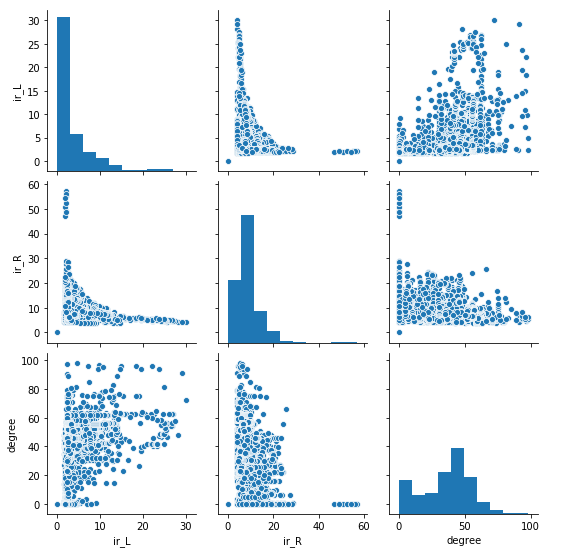

In [5]:
sns.pairplot(df, diag_kind='hist')

plt.show()

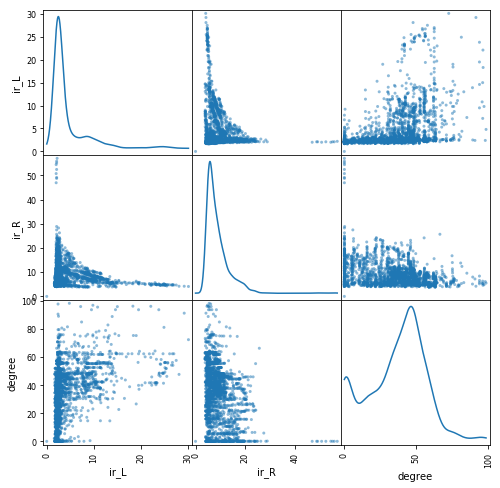

In [6]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()